# Algoritmos de ML para Regressão: Tuning dos Hiperparâmetros e Seleção de Variáveis

## Bibliotecas

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

## Função de Métricas de Avaliação

In [38]:
def show_results(y,y_pred):
    # Calcular os resultados
    var_exp = explained_variance_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Exibe resultados
    print("    Explained Variance Regression Score:{}".format(var_exp))
    print("    Mean Squared Error:{}".format(mse))
    print("    R^2 (coefficient of determination):{}".format(r2))

## Base de Dados

In [39]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

target = housing['target']
target = target[0:1001]

df_base = pd.DataFrame(data=housing['data'], columns=housing['feature_names'])
df_base = df_base.loc[0:1000]
df_base.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


## Descritivas - Resposta

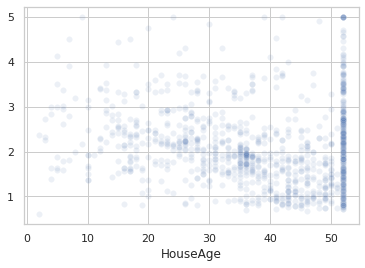

In [40]:
sns.scatterplot(x=df_base['HouseAge'], y=target, alpha=0.1)

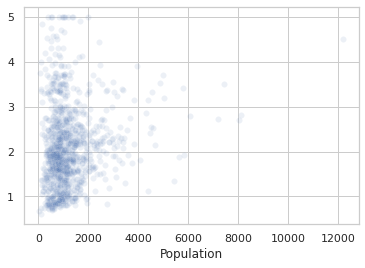

In [41]:
sns.scatterplot(x=df_base['Population'], y=target, alpha=0.1)

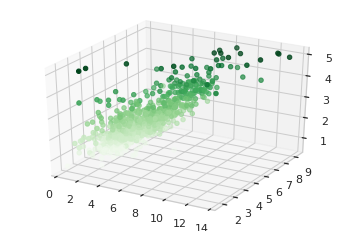

In [42]:
ax = plt.axes(projection='3d')

zdata = target
xdata = df_base['MedInc']
ydata = df_base['AveRooms']
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')
plt.show()

## Treino / Teste

In [43]:
from sklearn.model_selection import train_test_split

y = target
X = df_base.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 

## Linear Regression

### Melhores Hiperparâmetros

In [44]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()

# More Parameters: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
hyperparameters = dict(fit_intercept=[True, False])

randomizedsearch = RandomizedSearchCV(lin, hyperparameters, random_state=0, cv=5, verbose=0, n_jobs=-1, 
                                     scoring='neg_mean_squared_error')
lin_best = randomizedsearch.fit(X_train, y_train)
print(lin_best.best_params_) # Melhores hiperparâmetros

{'fit_intercept': False}


### Seleção de Variáveis

In [45]:
lin_best = LinearRegression(fit_intercept=False)

model = RFECV(estimator=lin_best, step=1, cv=5, scoring='neg_mean_squared_error', 
              min_features_to_select=2)
model = model.fit(X_train, y_train)

print("Número Ótimo de Features : %d" % model.n_features_)

Número Ótimo de Features : 8


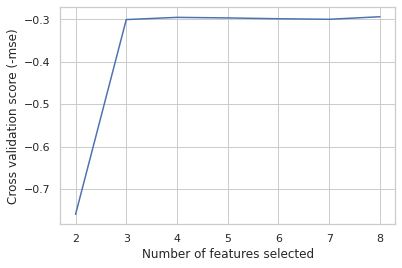

In [46]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (-mse)")
plt.plot(range(2, len(model.grid_scores_) + 2), model.grid_scores_)
plt.show()

### Avaliação

In [47]:
y_pred = model.predict(X_test)

show_results(y_test, y_pred)

    Explained Variance Regression Score:0.6537491011976173
    Mean Squared Error:0.2982738442984741
    R^2 (coefficient of determination):0.6535503882187084


In [48]:
model.estimator_.coef_

array([ 3.81799792e-01,  2.43072956e-03, -1.00654132e-02,  1.92813073e-01,
        9.77569057e-05, -1.62715490e-01,  1.78814627e+00,  5.46668909e-01])

In [49]:
model.estimator_.intercept_

0.0

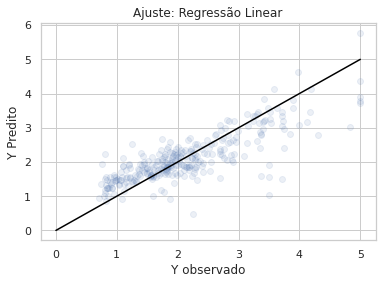

In [50]:
a = np.array([0, 5])
b = np.array([0, 5])
plt.scatter(y_test, y_pred, alpha=0.1)
plt.plot(a, b, color='black') # reta y=x
plt.title('Ajuste: Regressão Linear')
plt.xlabel('Y observado')
plt.ylabel('Y Predito')
plt.show()

## Decision Tree

### Melhores Hiperparâmetros

In [51]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=0)

# More Parameters: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
hyperparameters = dict(criterion=['mse', 'friedman_mse', 'mae', 'poisson'], 
                       splitter=['best', 'random'], max_depth=[50, 100, 200])

randomizedsearch = RandomizedSearchCV(tree, hyperparameters, random_state=0, cv=5, verbose=0, n_jobs=-1, 
                                     scoring='neg_mean_squared_error')
tree_best = randomizedsearch.fit(X_train, y_train)
print(tree_best.best_params_) # Melhores hiperparâmetros

{'splitter': 'best', 'max_depth': 200, 'criterion': 'friedman_mse'}


### Seleção de Variáveis

In [52]:
tree_best = DecisionTreeRegressor(random_state=0, splitter='best', max_depth=200, criterion='friedman_mse')

model = RFECV(estimator=tree_best, step=1, cv=5, scoring='neg_mean_squared_error', 
              min_features_to_select=2)
model = model.fit(X_train, y_train)

print("Número Ótimo de Features : %d" % model.n_features_)

Número Ótimo de Features : 8


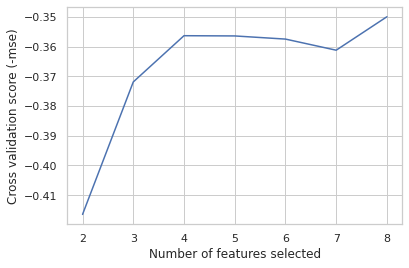

In [53]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (-mse)")
plt.plot(range(2, len(model.grid_scores_) + 2), model.grid_scores_)
plt.show()

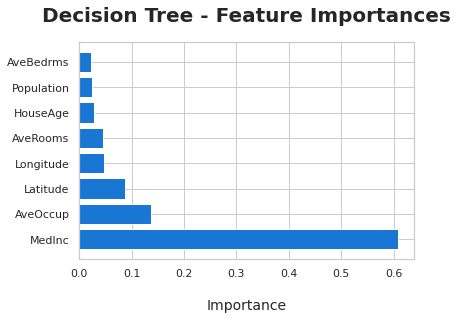

In [54]:
X_train2 = X_train.copy()
X_train2.drop(X.columns[np.where(model.support_ == False)[0]], axis=1, inplace=True)

dset = pd.DataFrame()
dset['attr'] = X_train2.columns
dset['importance'] = model.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)

plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('Decision Tree - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

### Avaliação

In [55]:
y_pred = model.predict(X_test)

show_results(y_test, y_pred)

    Explained Variance Regression Score:0.5888625463721897
    Mean Squared Error:0.3546055125601329
    R^2 (coefficient of determination):0.588120297805836


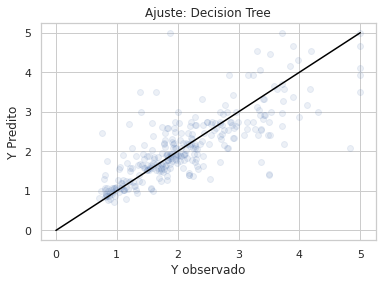

In [56]:
a = np.array([0, 5])
b = np.array([0, 5])
plt.scatter(y_test, y_pred, alpha=0.1)
plt.plot(a, b, color='black') # reta y=x
plt.title('Ajuste: Decision Tree')
plt.xlabel('Y observado')
plt.ylabel('Y Predito')
plt.show()

## Random Forest

### Melhores Hiperparâmetros

In [57]:
from sklearn.ensemble import RandomForestRegressor

tree = RandomForestRegressor(random_state=0)

# More Parameters: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
hyperparameters = dict(criterion=['mse', 'mae'], n_estimators=[50,100,200], max_depth=[50, 100, 200])

randomizedsearch = RandomizedSearchCV(tree, hyperparameters, random_state=0, cv=5, verbose=0, n_jobs=-1, 
                                     scoring='neg_mean_squared_error')
tree_best = randomizedsearch.fit(X_train, y_train)
print(tree_best.best_params_) # Melhores hiperparâmetros

{'n_estimators': 100, 'max_depth': 50, 'criterion': 'mse'}


### Seleção de Variáveis

In [58]:
tree_best = RandomForestRegressor(random_state=0, n_estimators=100, max_depth=50, criterion='mse')

model = RFECV(estimator=tree_best, step=1, cv=5, scoring='neg_mean_squared_error', 
              min_features_to_select=2)
model = model.fit(X_train, y_train)

print("Número Ótimo de Features : %d" % model.n_features_)

Número Ótimo de Features : 5


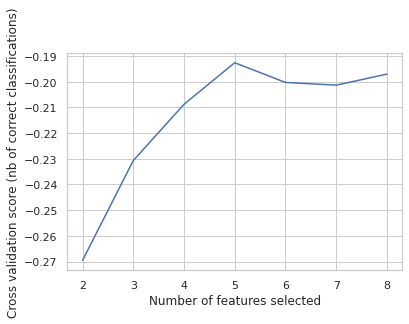

In [59]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(2, len(model.grid_scores_) + 2), model.grid_scores_)
plt.show()

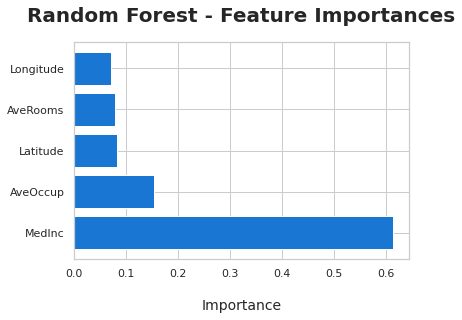

In [60]:
X_train2 = X_train.copy()
X_train2.drop(X.columns[np.where(model.support_ == False)[0]], axis=1, inplace=True)

dset = pd.DataFrame()
dset['attr'] = X_train2.columns
dset['importance'] = model.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)

plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('Random Forest - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

### Avaliação

In [61]:
y_pred = model.predict(X_test)

show_results(y_test, y_pred)

    Explained Variance Regression Score:0.784516824823591
    Mean Squared Error:0.18570737352938502
    R^2 (coefficient of determination):0.7842980579960028


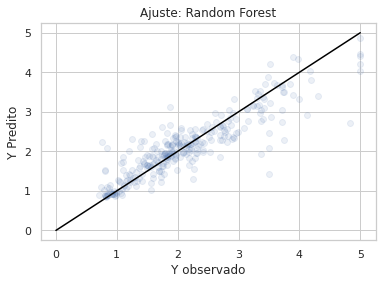

In [62]:
a = np.array([0, 5])
b = np.array([0, 5])
plt.scatter(y_test, y_pred, alpha=0.1)
plt.plot(a, b, color='black') # reta y=x
plt.title('Ajuste: Random Forest')
plt.xlabel('Y observado')
plt.ylabel('Y Predito')
plt.show()

## SVM

### Melhores Hiperparâmetros

In [63]:
from sklearn.svm import SVR

svm = SVR()

# More Parameters: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
hyperparameters = dict(C=[1,0.1], kernel=['linear'],
                      gamma=['scale'])

randomizedsearch = RandomizedSearchCV(svm, hyperparameters, random_state=0, cv=5, verbose=0, n_jobs=-1, 
                                     scoring='neg_mean_squared_error')
svm_best = randomizedsearch.fit(X_train, y_train)
print(svm_best.best_params_) # Melhores hiperparâmetros

{'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}


### Seleção de Variáveis

In [64]:
svm_best = SVR(kernel='linear', gamma='scale', C=0.1)

model = RFECV(estimator=svm_best, step=1, cv=5, scoring='neg_mean_squared_error', 
              min_features_to_select=2)
model = model.fit(X_train, y_train)

print("Número Ótimo de Features : %d" % model.n_features_)

Número Ótimo de Features : 4


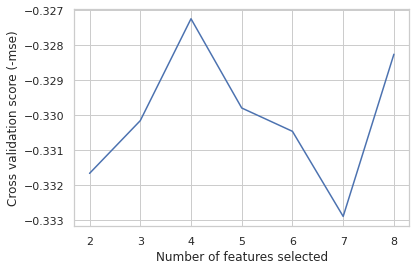

In [65]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (-mse)")
plt.plot(range(2, len(model.grid_scores_) + 2), model.grid_scores_)
plt.show()

### Avaliação

In [66]:
y_pred = model.predict(X_test)

show_results(y_test, y_pred)

    Explained Variance Regression Score:0.5643998447115215
    Mean Squared Error:0.3853619467214457
    R^2 (coefficient of determination):0.5523962312185526


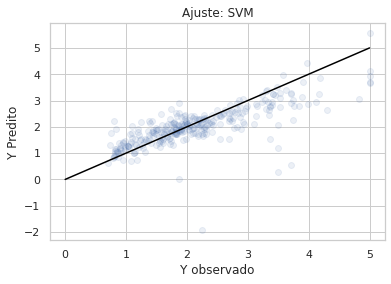

In [67]:
a = np.array([0, 5])
b = np.array([0, 5])
plt.scatter(y_test, y_pred, alpha=0.1)
plt.plot(a, b, color='black') # reta y=x
plt.title('Ajuste: SVM')
plt.xlabel('Y observado')
plt.ylabel('Y Predito')
plt.show()

## RNA

### Melhores Hiperparâmetros

In [68]:
from sklearn.neural_network import MLPRegressor

rna = MLPRegressor(random_state=0)

# More Parameters: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
hyperparameters = dict(hidden_layer_sizes=[(50,), (100,), (150,)], activation=['identity', 'logistic', 'tanh', 'relu'],
                      solver=['lbfgs', 'sgd', 'adam'], alpha=[0.0001, 0.001, 0.01],
                      learning_rate=['constant', 'invscaling', 'adaptive'])

randomizedsearch = RandomizedSearchCV(rna, hyperparameters, random_state=0, cv=5, verbose=0, n_jobs=-1, 
                                     scoring='neg_mean_squared_error')
rna_best = randomizedsearch.fit(X_train, y_train)
print(rna_best.best_params_) # Melhores hiperparâmetros

{'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (150,), 'alpha': 0.0001, 'activation': 'logistic'}


### Avaliação

In [69]:
y_pred = rna_best.predict(X_test)

show_results(y_test, y_pred)

    Explained Variance Regression Score:0.5756412383931504
    Mean Squared Error:0.4195883114044073
    R^2 (coefficient of determination):0.5126417874959202


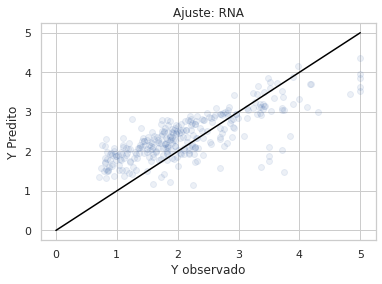

In [70]:
a = np.array([0, 5])
b = np.array([0, 5])
plt.scatter(y_test, y_pred, alpha=0.1)
plt.plot(a, b, color='black') # reta y=x
plt.title('Ajuste: RNA')
plt.xlabel('Y observado')
plt.ylabel('Y Predito')
plt.show()